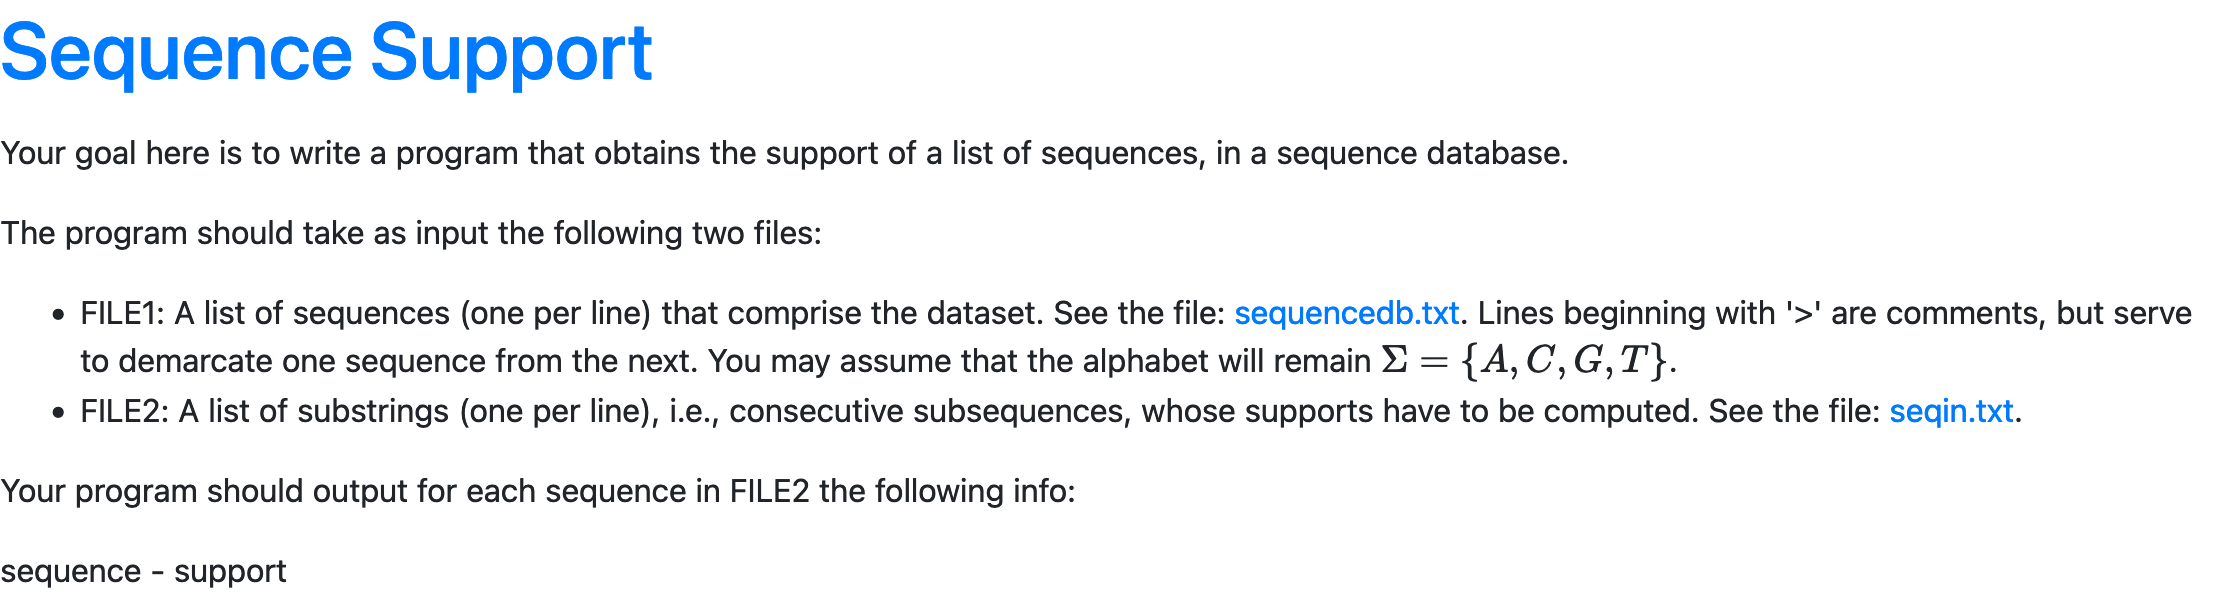

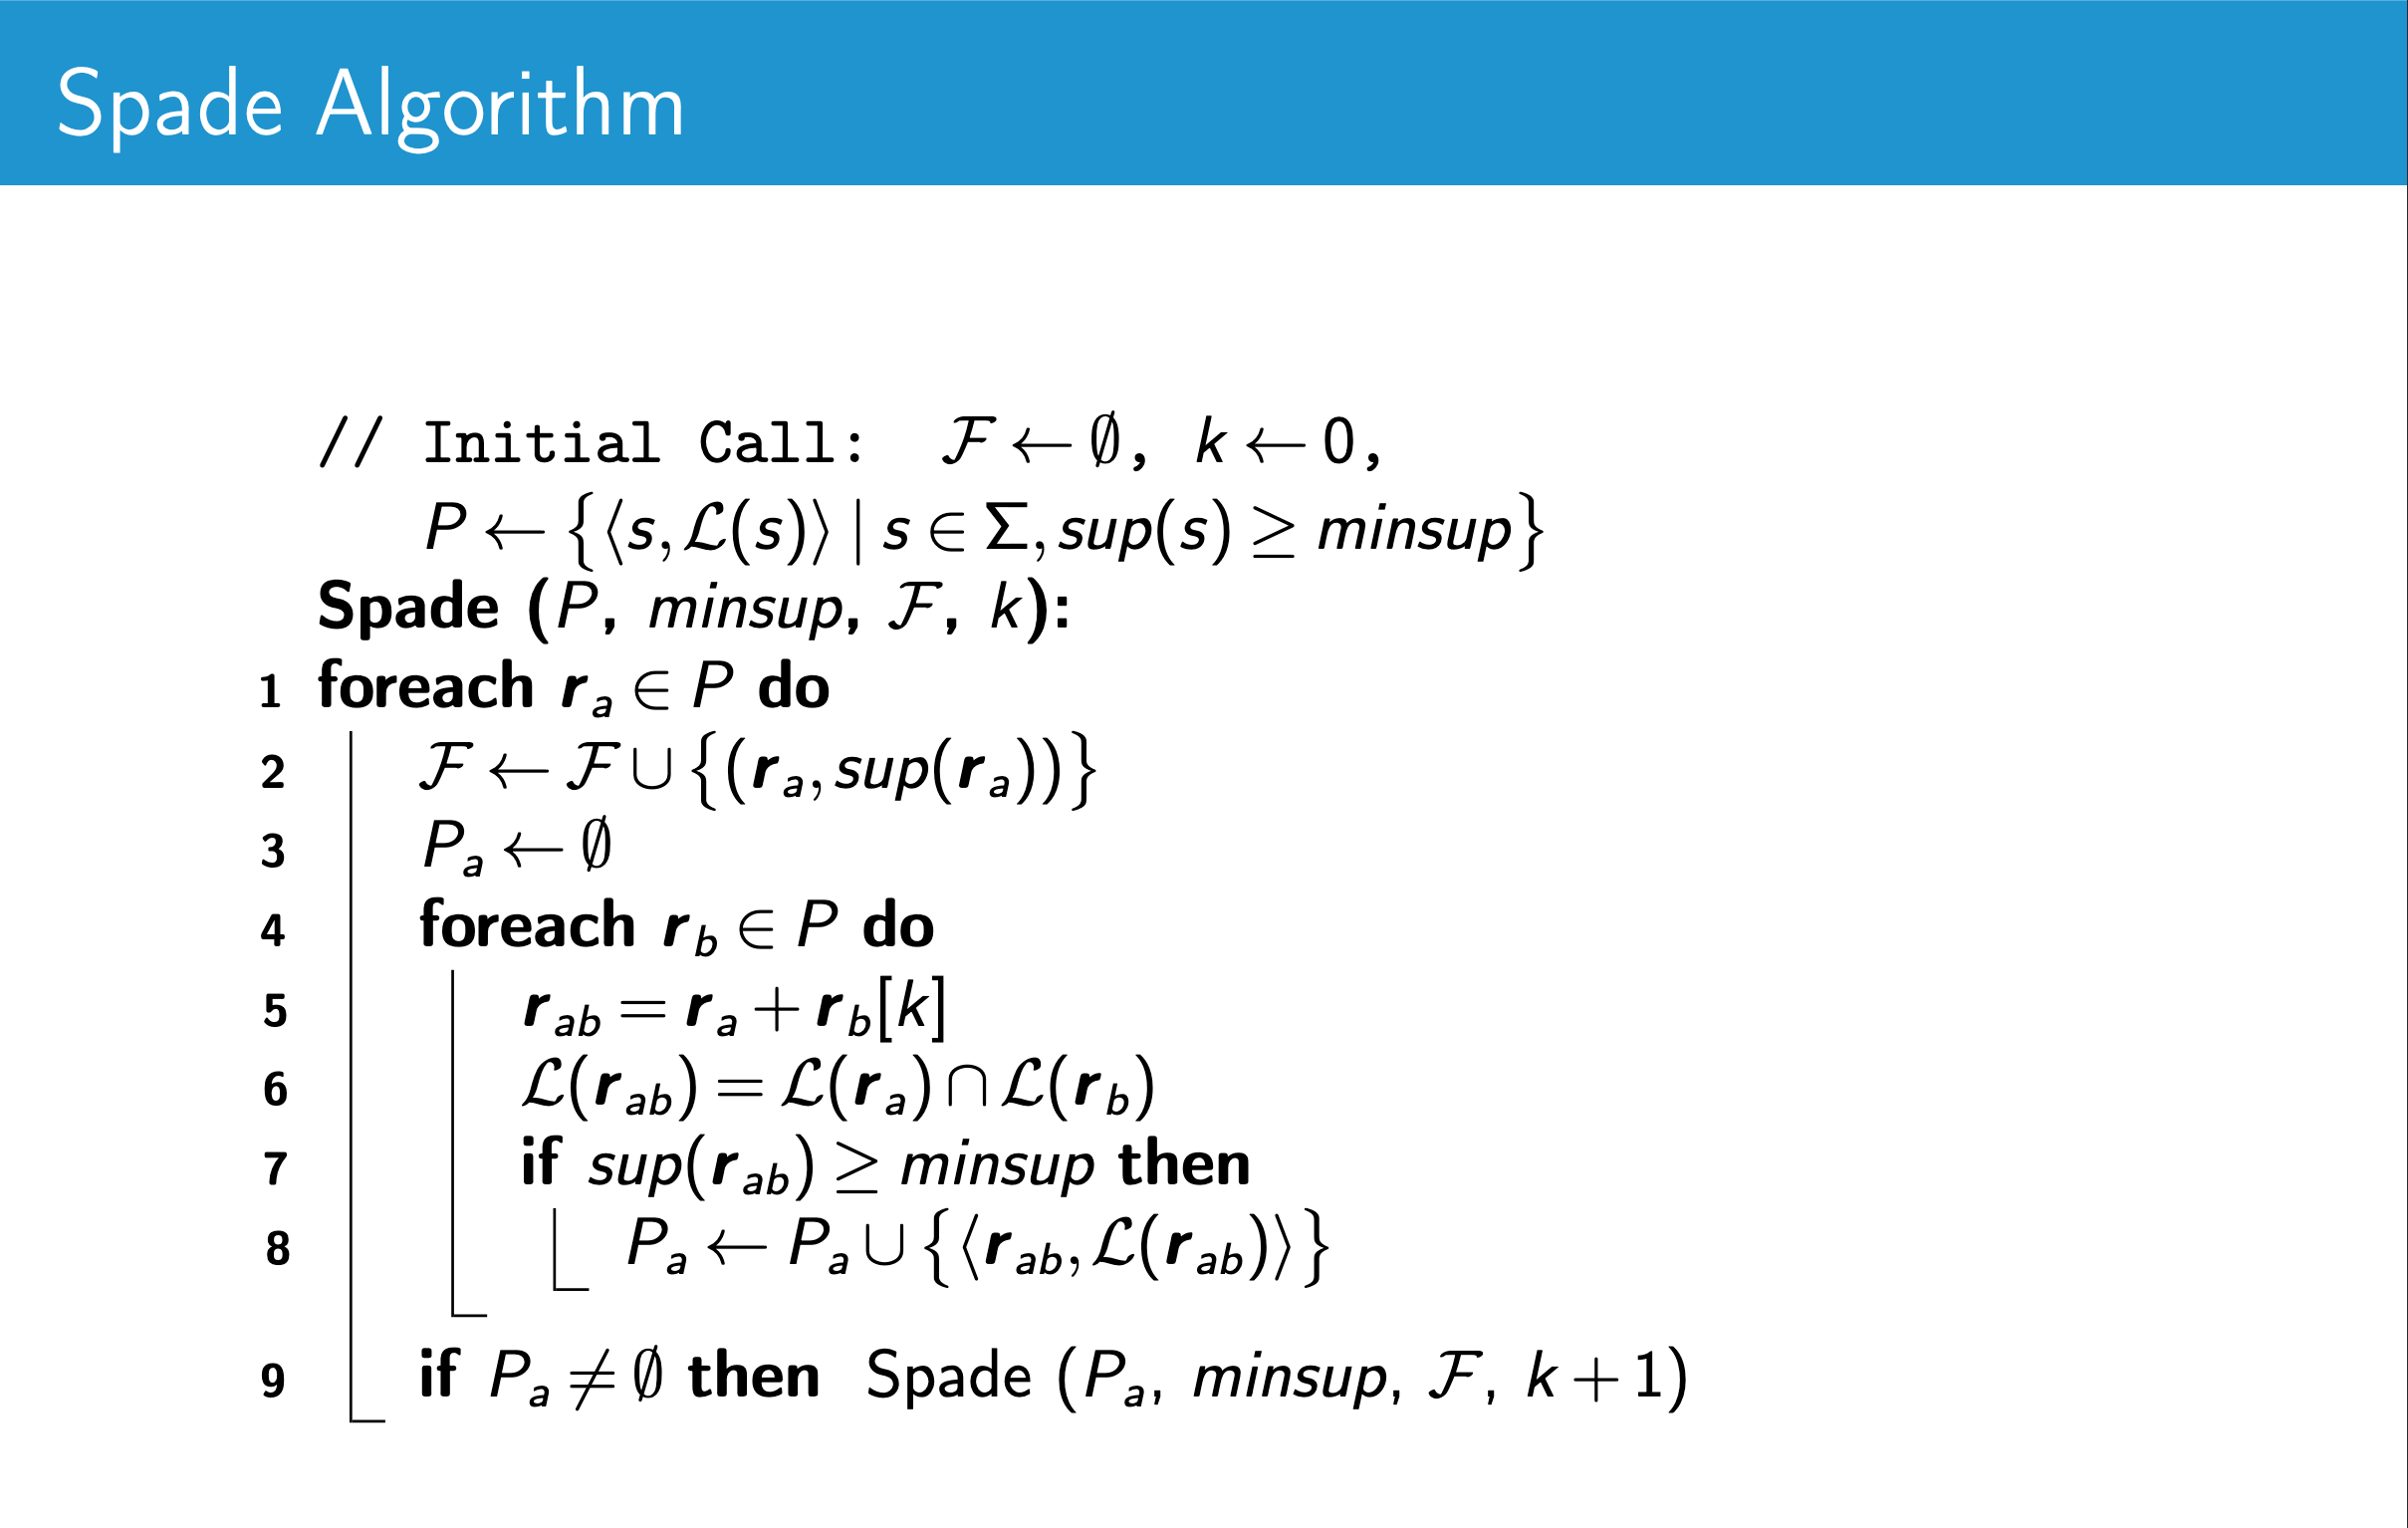

In [1]:
from collections import defaultdict

In [2]:
with open('data/sequencedb.txt', 'r') as f:
    sequences_db = [line.strip() for line in f if not line.startswith('>')]

with open('data/seqin.txt', 'r') as f:
    sequences_query = [line.strip() for line in f]

ALPHABET = ['A', 'C', 'G', 'T']

In [3]:
class SeqPosList:
    def __init__(self, sequence):
        self.sequence = sequence
        self.positions = defaultdict(list)  # {sequence_index: [positions_in_sequence]}

    def join_with(self, other):
        """
        Combine position data from two SeqPosList objects if their sequences can be merged.
        """
        assert self.sequence[:-1] == other.sequence[:-1], "Sequences must share the same prefix"
        
        new_positions = defaultdict(list)

        for seq_idx in other.positions:
            if seq_idx in self.positions:
                for pos in other.positions[seq_idx]:
                    if any(p < pos for p in self.positions[seq_idx]):
                        new_positions[seq_idx].append(pos)

        result = SeqPosList(self.sequence + other.sequence[-1])
        result.positions = new_positions
        return result

In [4]:
# Preprocessing: Initialize base position lists for single symbols in the alphabet
poslist_db = {symbol: SeqPosList(symbol) for symbol in ALPHABET}

for seq_idx, sequence in enumerate(sequences_db):
    for pos, char in enumerate(sequence):
        poslist_db[char].positions[seq_idx].append(pos)

In [5]:
def compute_support(sequence):
    """
    Compute the support of a sequence in the database and store the result.
    """
    if sequence in poslist_db:
        return poslist_db[sequence]

    # Split sequence into two parts: the prefix and the last character
    prefix_support = compute_support(sequence[:-1])
    suffix_support = compute_support(sequence[:-2] + sequence[-1])

    # If either prefix or suffix has no support, return an empty result
    if not prefix_support.positions or not suffix_support.positions:
        poslist_db[sequence] = SeqPosList(sequence)
        return poslist_db[sequence]

    # Combine prefix and suffix to compute full support
    combined_support = prefix_support.join_with(suffix_support)
    poslist_db[sequence] = combined_support
    return combined_support

In [6]:
for query in sequences_query:
    support = compute_support(query)
    print(f"Support of {query} is: {len(support.positions)}")

Support of TAT is: 1062
Support of CCAA is: 1061
Support of CAGAA is: 1061
Support of TCATTT is: 1062
Support of GCCG is: 1056
Support of GTCAA is: 1060
Support of ACGT is: 1062
Support of CAAAAAA is: 1062
Support of AAAAAA is: 1062
Support of AGGCT is: 1054
Support of TTTAAACCCGG is: 1038
Support of TAGGCA is: 1053


There are a total of 1062 sequences in the database, let's check if my implementation is correct

In [7]:
def find_missing_indices(query):
    """
    Find the indices of sequences in the database that do not contain the query.
    """
    all_indices = set(range(len(sequences_db)))
    present_indices = set(poslist_db[query].positions.keys())
    return all_indices - present_indices


In [8]:
for query in sequences_query:
    compute_support(query)
    missing_indices = find_missing_indices(query)
    print(f"Sequences not containing '{query}': {len(missing_indices)} sequences")
    print(f"Missing indices: {sorted(missing_indices)[:10]}{'...' if len(missing_indices) > 10 else ''}")


Sequences not containing 'TAT': 0 sequences
Missing indices: []
Sequences not containing 'CCAA': 1 sequences
Missing indices: [31]
Sequences not containing 'CAGAA': 1 sequences
Missing indices: [30]
Sequences not containing 'TCATTT': 0 sequences
Missing indices: []
Sequences not containing 'GCCG': 6 sequences
Missing indices: [30, 31, 138, 242, 368, 522]
Sequences not containing 'GTCAA': 2 sequences
Missing indices: [30, 31]
Sequences not containing 'ACGT': 0 sequences
Missing indices: []
Sequences not containing 'CAAAAAA': 0 sequences
Missing indices: []
Sequences not containing 'AAAAAA': 0 sequences
Missing indices: []
Sequences not containing 'AGGCT': 8 sequences
Missing indices: [30, 31, 234, 235, 295, 523, 634, 635]
Sequences not containing 'TTTAAACCCGG': 24 sequences
Missing indices: [30, 31, 48, 66, 83, 120, 138, 162, 163, 205]...
Sequences not containing 'TAGGCA': 9 sequences
Missing indices: [30, 31, 163, 204, 234, 295, 523, 634, 742]


Looks like I did the right thing